## **Import Libraries**

In [29]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import DataLoader, random_split
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torchvision.utils as vutils

## Define the available device

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Loading Dataset**

In [31]:
# Define transformations for SVHN images
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load SVHN dataset
full_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)

# Split dataset into training, validation, and test sets
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Randomly split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# DataLoader for training set
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# DataLoader for validation set
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# DataLoader for test set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Using downloaded and verified file: ./data/train_32x32.mat


## Visualising Dataset

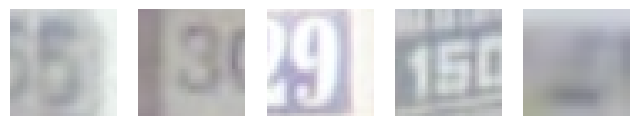

In [32]:
# Function to display images from the dataset
def show_images(dataset_loader, num_images=5):
    data_iter = iter(dataset_loader)
    images, _ = next(data_iter)

    # Denormalize images
    images = images * 0.5 + 0.5

    fig, axes = plt.subplots(1, num_images, figsize=(8, 2))
    for i in range(num_images):
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

# Show a few images from the training dataset
show_images(train_loader)

## **Autoencoder**

In [33]:
# Autoencoder base class
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        """
        Initialize the Autoencoder.

        Parameters:
        - encoder (nn.Module): Encoder network.
        - decoder (nn.Module): Decoder network.
        """
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        """
        Forward pass of the autoencoder.

        Parameters:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor.
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## **Train and Validation Loss Calculation**

In [34]:
import torch

# Function to train and validate the autoencoder
def train_and_validate_autoencoder(autoencoder, train_loader, val_loader, optimizer, criterion, epochs):
    """
    Train and validate the autoencoder model.

    Parameters:
    - autoencoder (nn.Module): Autoencoder model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - optimizer (torch.optim.Optimizer): Optimizer for training.
    - criterion (torch.nn.Module): Loss criterion for training.
    - epochs (int): Number of training epochs.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    """
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training
        autoencoder.train()
        total_train_loss = 0.0
        for batch_features, _ in train_loader:
            # Prepare batch data and move to device
            batch_features = batch_features.view(-1, 32 * 32 * 3).to(device)

            # Zero the gradients, forward pass, backward pass, and optimization
            optimizer.zero_grad()
            outputs = autoencoder(batch_features)
            loss = criterion(outputs, batch_features)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        autoencoder.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch_features, _ in val_loader:
                # Prepare batch data and move to device
                batch_features = batch_features.view(-1, 32 * 32 * 3).to(device)

                # Forward pass and calculate validation loss
                outputs = autoencoder(batch_features)
                val_loss = criterion(outputs, batch_features)
                total_val_loss += val_loss.item()

        # Calculate average validation loss for the epoch
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Save the model at the end of each epoch
        torch.save(autoencoder.state_dict(), f"{autoencoder.__class__.__name__}_epoch{epoch+1}.pt")

        # Display epoch information
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    return train_losses, val_losses


## **Undercomplete Autoencoder**

In [35]:
# Undercomplete Autoencoder
class UnderCompleteAutoencoder(nn.Module):
    def __init__(self):
        """
        Initialize the UnderCompleteAutoencoder model.

        Architecture:
        - Encoder: Three fully connected layers with ReLU activation
        - Decoder: Three fully connected layers with ReLU activation (last layer with Sigmoid activation)

        Input:
        - 32 * 32 * 3: Flattened input size for SVHN images.

        Output:
        - Same size as the input, representing the reconstructed image.

        """
        super(UnderCompleteAutoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(32 * 32 * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),  # Additional layer
            nn.ReLU(),
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),  # Additional layer
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 32 * 32 * 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass of the autoencoder.

        Parameters:
        - x (torch.Tensor): Input data (flattened SVHN image).

        Returns:
        - x (torch.Tensor): Reconstructed output.
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [36]:
# Instantiate and train the undercomplete autoencoder with metrics
undercomplete_autoencoder = UnderCompleteAutoencoder().to(device)
optimizer_undercomplete = optim.Adam(undercomplete_autoencoder.parameters(), lr=1e-3)
criterion_undercomplete = nn.MSELoss()

epochs_undercomplete = 10

# Train and validate the undercomplete autoencoder
undercomplete_train_losses, undercomplete_val_losses = train_and_validate_autoencoder(
    undercomplete_autoencoder, train_loader, val_loader, optimizer_undercomplete, criterion_undercomplete, epochs_undercomplete
)


Epoch 1/10, Train Loss: 0.0130352817224664, Val Loss: 0.010085165678806927
Epoch 2/10, Train Loss: 0.00885271052748583, Val Loss: 0.007968998461475838
Epoch 3/10, Train Loss: 0.007343767015121096, Val Loss: 0.006980224111643822
Epoch 4/10, Train Loss: 0.006424533113263808, Val Loss: 0.006185401032638291
Epoch 5/10, Train Loss: 0.006007061829977551, Val Loss: 0.006036244587891776
Epoch 6/10, Train Loss: 0.005576073167150165, Val Loss: 0.0053725080929048685
Epoch 7/10, Train Loss: 0.005196684367515505, Val Loss: 0.005007567677808845
Epoch 8/10, Train Loss: 0.004908205011521983, Val Loss: 0.004871228450666303
Epoch 9/10, Train Loss: 0.004671799588600767, Val Loss: 0.0046068735117011745
Epoch 10/10, Train Loss: 0.0044614001940813846, Val Loss: 0.0044534600481552925


## **Sparse Autoencoder**

In [37]:
import torch.nn as nn

# Sparse Autoencoder
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, sparsity_param=0.05):
        super(SparseAutoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),        # Fully connected layer for encoding
            nn.ReLU(),                              # ReLU activation function
            nn.Linear(hidden_dim, int(hidden_dim*0.5)),  # Fully connected layer for encoding
            nn.ReLU(),                              # ReLU activation function
            nn.Linear(int(hidden_dim*0.5), int(hidden_dim*0.25)),  # Additional layer for encoding
            nn.ReLU()                               # ReLU activation function
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(int(hidden_dim*0.25), int(hidden_dim*0.5)),  # Additional layer for decoding
            nn.ReLU(),                              # ReLU activation function
            nn.Linear(int(hidden_dim*0.5), hidden_dim),  # Fully connected layer for decoding
            nn.ReLU(),                              # ReLU activation function
            nn.Linear(hidden_dim, input_dim),        # Fully connected layer for decoding
            nn.Sigmoid()                            # Sigmoid activation function for output
        )

        # Sparsity parameters
        self.sparsity_param = sparsity_param
        self.kl_div_loss = nn.KLDivLoss(reduction='batchmean')  # KL Divergence loss

    def forward(self, x):
        # Forward pass of the autoencoder
        encoded = self.encoder(x)  # Encoding
        decoded = self.decoder(encoded)  # Decoding
        return decoded

    def compute_sparsity_loss(self, x):
        # Compute the sparsity loss based on Kullback-Leibler Divergence
        encoded = self.encoder(x)  # Encoding
        avg_activation = torch.mean(torch.sigmoid(encoded), dim=0)  # Calculate average activation
        sparsity_loss = self.kl_div_loss(avg_activation, torch.tensor([self.sparsity_param]*len(avg_activation)).to(device))
        return sparsity_loss

In [38]:
# Instantiate the sparsity-constrained autoencoder
input_dim = 32*32*3
hidden_dim = 256
sparsity_autoencoder = SparseAutoencoder(input_dim, hidden_dim).to(device)
optimizer_sparsity = optim.Adam(sparsity_autoencoder.parameters(), lr=1e-3)
criterion_sparsity = nn.MSELoss()

# Training loop with sparsity constraint
epochs_sparsity = 10
sparsity_weight = 0.1

sparsity_train_losses, sparsity_val_losses = train_and_validate_autoencoder(
    sparsity_autoencoder, train_loader, val_loader, optimizer_sparsity, criterion_sparsity, epochs_sparsity
)

Epoch 1/10, Train Loss: 0.013027333886277206, Val Loss: 0.009499086759498586
Epoch 2/10, Train Loss: 0.009131473636531218, Val Loss: 0.008225272875279188
Epoch 3/10, Train Loss: 0.00792128824340139, Val Loss: 0.0075092372403520605
Epoch 4/10, Train Loss: 0.007079645390947671, Val Loss: 0.006948015332707893
Epoch 5/10, Train Loss: 0.0066674434286074545, Val Loss: 0.006672496575376262
Epoch 6/10, Train Loss: 0.006416720824669965, Val Loss: 0.006352727337861838
Epoch 7/10, Train Loss: 0.006182060080812227, Val Loss: 0.006133268558946641
Epoch 8/10, Train Loss: 0.005966932619576175, Val Loss: 0.005767827902151191
Epoch 9/10, Train Loss: 0.005696146854699699, Val Loss: 0.005597824866519026
Epoch 10/10, Train Loss: 0.005455260133771348, Val Loss: 0.005427164564152127


### **Plot between train loss and validation loss vs epochs**

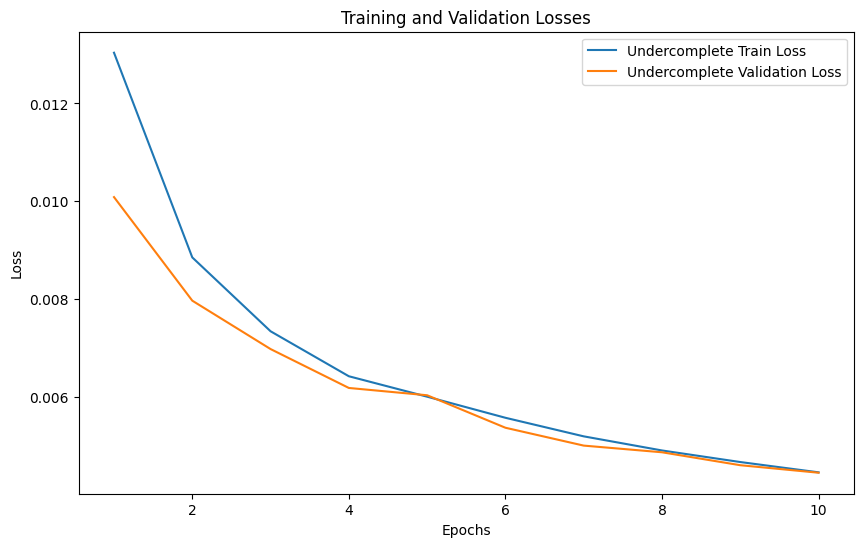

In [39]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs_undercomplete+1), undercomplete_train_losses, label='Undercomplete Train Loss')
plt.plot(range(1, epochs_undercomplete+1), undercomplete_val_losses, label='Undercomplete Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

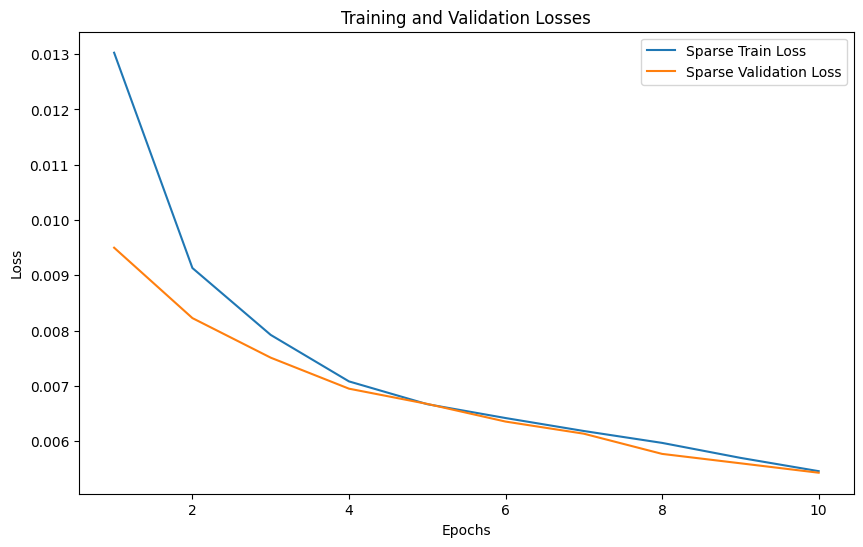

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs_sparsity+1), sparsity_train_losses, label='Sparse Train Loss')
plt.plot(range(1, epochs_sparsity+1), sparsity_val_losses, label='Sparse Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

### **Testing and Visualing the test dataset**

In [41]:
def test_autoencoder(autoencoder, test_loader):
    # Set the autoencoder to evaluation mode
    autoencoder.eval()

    # Lists to store SSIM and PSNR scores for each image
    test_ssim_scores = []
    test_psnr_scores = []

    with torch.no_grad():
        # Iterate through the test loader
        for batch_features, _ in test_loader:
            # Move batch to the device
            batch_features = batch_features.view(-1, 32 * 32 * 3).to(device)

            # Obtain the reconstructed outputs from the autoencoder
            outputs = autoencoder(batch_features)

            # Calculate SSIM and PSNR for each image in the batch
            for i in range(len(outputs)):
                img_gt = batch_features[i].cpu().numpy().reshape(3, 32, 32).transpose(1, 2, 0)
                img_pred = outputs[i].cpu().numpy().reshape(3, 32, 32).transpose(1, 2, 0)

                ssim_score = ssim(img_gt, img_pred, multichannel=True)
                psnr_score = psnr(img_gt, img_pred, data_range=img_pred.max() - img_pred.min())

                # Append the scores to the lists
                test_ssim_scores.append(ssim_score)
                test_psnr_scores.append(psnr_score)

    # Calculate average SSIM and PSNR scores
    avg_test_ssim = sum(test_ssim_scores) / len(test_ssim_scores)
    avg_test_psnr = sum(test_psnr_scores) / len(test_psnr_scores)

    # Print the average scores
    print(f"Average Test SSIM: {avg_test_ssim}, Average Test PSNR: {avg_test_psnr}")

    # Visualize a batch of images (input vs reconstructed)
    original_images = vutils.make_grid(batch_features.view(-1, 3, 32, 32).cpu(), nrow=8, normalize=True)
    reconstructed_images = vutils.make_grid(outputs.view(-1, 3, 32, 32).cpu(), nrow=8, normalize=True)

    # Display the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Images")
    plt.imshow(np.transpose(original_images, (1, 2, 0)))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Images")
    plt.imshow(np.transpose(reconstructed_images, (1, 2, 0)))
    plt.axis('off')

    plt.show()


<ipython-input-41-ae0e612ea444>:23: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(img_gt, img_pred, multichannel=True)


Average Test SSIM: 0.8089504117560253, Average Test PSNR: 18.25358032708859


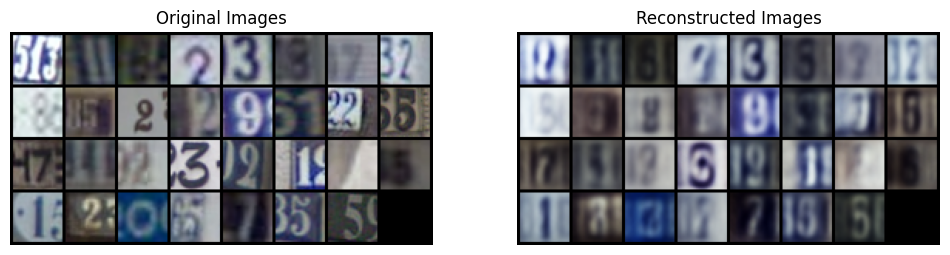

Average Test SSIM: 0.7708561128477974, Average Test PSNR: 16.688447630235405


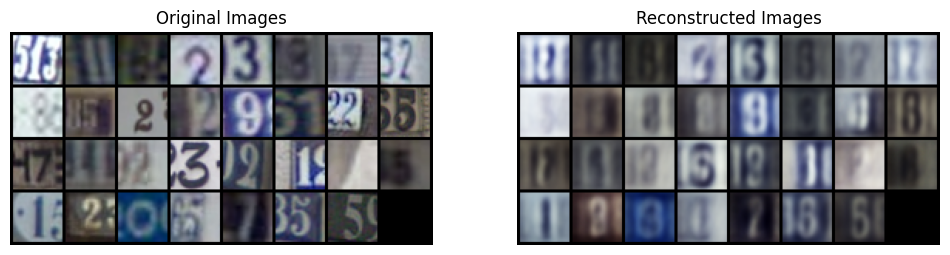

In [42]:
# Test the undercomplete autoencoder
test_autoencoder(undercomplete_autoencoder, test_loader)

# Test the sparse autoencoder
test_autoencoder(sparsity_autoencoder, test_loader)